In [3]:
# Imports, paths (raw COCO source and output detector dataset root), class list, and random seed
import os
import json
import random
import shutil
from collections import Counter, defaultdict
from pathlib import Path

import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Paths (aligned to classification dataset layout)
BASE_DATA_ROOT = Path("/Users/stephenmacris/Documents/School/CS5100/Project/CarDD_release/CarDD_COCO")

TRAIN_IMG_DIR = BASE_DATA_ROOT / "train2017"
VAL_IMG_DIR = BASE_DATA_ROOT / "val2017"
TEST_IMG_DIR = BASE_DATA_ROOT / "test2017"

TRAIN_ANN = BASE_DATA_ROOT / "annotations" / "instances_train2017.json"
VAL_ANN = BASE_DATA_ROOT / "annotations" / "instances_val2017.json"
TEST_ANN = BASE_DATA_ROOT / "annotations" / "instances_test2017.json"

OUTPUT_ROOT = Path("/Users/stephenmacris/Documents/School/CS5100/Project/CarDD_release/CarDD_COCO/detector")
SPLITS = ["train", "val", "test"]

# Ensure output folders exist
for split in SPLITS:
    (OUTPUT_ROOT / split / "images").mkdir(parents=True, exist_ok=True)
    (OUTPUT_ROOT / split / "annotations").mkdir(parents=True, exist_ok=True)


In [4]:
# Load COCO annotations for train/val/test; basic sanity checks (images/annotations match, category IDs).
def load_coco(json_path: Path):
    with open(json_path, "r") as f:
        return json.load(f)

def summarize_split(split_name, coco):
    image_ids = {img["id"] for img in coco["images"]}
    ann_image_ids = {ann["image_id"] for ann in coco["annotations"]}
    cat_ids = {c["id"] for c in coco["categories"]}
    ann_cat_ids = {ann["category_id"] for ann in coco["annotations"]}

    missing_images = sorted(list(ann_image_ids - image_ids))
    unused_images = sorted(list(image_ids - ann_image_ids))
    unknown_cats = sorted(list(ann_cat_ids - cat_ids))

    print(f"{split_name}: {len(coco['images'])} images, {len(coco['annotations'])} annotations, {len(coco['categories'])} categories")
    if missing_images:
        preview = missing_images[:5]
        print(f"  annotations referencing missing images: {preview}{'...' if len(missing_images) > 5 else ''}")
    if unused_images:
        preview = unused_images[:5]
        print(f"  images without annotations: {preview}{'...' if len(unused_images) > 5 else ''}")
    if unknown_cats:
        print(f"  annotations with unknown categories: {unknown_cats}")

coco_splits = {}
SPLIT_CONFIG = {
    "train": {"ann": TRAIN_ANN, "img_dir": TRAIN_IMG_DIR},
    "val": {"ann": VAL_ANN, "img_dir": VAL_IMG_DIR},
    "test": {"ann": TEST_ANN, "img_dir": TEST_IMG_DIR},
}

for split, cfg in SPLIT_CONFIG.items():
    coco_splits[split] = load_coco(cfg["ann"])
    summarize_split(split, coco_splits[split])


train: 2816 images, 6211 annotations, 6 categories
val: 810 images, 1744 annotations, 6 categories
test: 374 images, 785 annotations, 6 categories


In [5]:
# Define helpers to remap category IDs, normalize/check bounding boxes, and filter bad annotations (zero-area, out-of-bounds)
def build_category_maps(categories):
    cat_id_to_name = {c["id"]: c["name"] for c in categories}
    sorted_ids = sorted(cat_id_to_name.keys())
    cat_id_to_new = {cid: idx + 1 for idx, cid in enumerate(sorted_ids)}  # 1-based
    remapped_categories = [
        {"id": cat_id_to_new[cid], "name": cat_id_to_name[cid]} for cid in sorted_ids
    ]
    return cat_id_to_new, remapped_categories

def clamp_bbox(bbox, width, height):
    x, y, w, h = bbox
    x = max(0.0, min(float(x), float(width)))
    y = max(0.0, min(float(y), float(height)))
    w = max(0.0, min(float(w), float(width) - x))
    h = max(0.0, min(float(h), float(height) - y))
    return [x, y, w, h]

def is_valid_bbox(bbox):
    x, y, w, h = bbox
    return w > 1e-3 and h > 1e-3

def clean_annotations(coco, cat_id_to_new):
    images = {img["id"]: img for img in coco["images"]}
    cleaned = []
    dropped = {"bad_cat": 0, "missing_image": 0, "bad_bbox": 0}

    for ann in coco["annotations"]:
        img = images.get(ann["image_id"])
        if img is None:
            dropped["missing_image"] += 1
            continue

        new_cat = cat_id_to_new.get(ann["category_id"])
        if new_cat is None:
            dropped["bad_cat"] += 1
            continue

        bbox = ann.get("bbox", [0, 0, 0, 0])
        bbox = clamp_bbox(bbox, img["width"], img["height"])
        if not is_valid_bbox(bbox):
            dropped["bad_bbox"] += 1
            continue

        cleaned.append({
            **ann,
            "bbox": bbox,
            "area": bbox[2] * bbox[3],
            "category_id": new_cat,
        })

    return cleaned, dropped


In [6]:
# If needed, split data for detector (e.g., derive detector-specific splits or reuse raw ones) and copy/link images into detector dataset structure.
cat_id_to_new, remapped_categories = build_category_maps(coco_splits["train"]["categories"])
print("Category remap:", cat_id_to_new)

cleaned_splits = {}
for split, coco in coco_splits.items():
    cleaned_annotations, dropped = clean_annotations(coco, cat_id_to_new)
    cleaned_splits[split] = {
        "images": coco["images"],
        "annotations": cleaned_annotations,
        "categories": remapped_categories,
    }
    print(f"{split}: kept {len(cleaned_annotations)} annotations; dropped {dropped}")

def copy_images(split):
    src_dir = SPLIT_CONFIG[split]["img_dir"]
    dst_dir = OUTPUT_ROOT / split / "images"
    missing = []

    for img in coco_splits[split]["images"]:
        src = src_dir / img["file_name"]
        dst = dst_dir / img["file_name"]
        if not src.exists():
            missing.append(img["file_name"])
            continue
        if not dst.exists():
            shutil.copy2(src, dst)

    if missing:
        print(f"{split}: missing {len(missing)} image files; examples: {missing[:5]}")
    else:
        print(f"{split}: copied/verified {len(coco_splits[split]['images'])} images")

for split in SPLITS:
    copy_images(split)


Category remap: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
train: kept 6211 annotations; dropped {'bad_cat': 0, 'missing_image': 0, 'bad_bbox': 0}
val: kept 1744 annotations; dropped {'bad_cat': 0, 'missing_image': 0, 'bad_bbox': 0}
test: kept 785 annotations; dropped {'bad_cat': 0, 'missing_image': 0, 'bad_bbox': 0}
train: copied/verified 2816 images
val: copied/verified 810 images
test: copied/verified 374 images


In [7]:
# Write cleaned COCO detection annotations for each split (images, annotations, categories) 
# to output/train|val|test/annotations.json; log counts (per-class annotation histograms).

def write_split(split, data):
    out_path = OUTPUT_ROOT / split / "annotations" / "annotations.json"
    payload = {
        "images": data["images"],
        "annotations": data["annotations"],
        "categories": data["categories"],
    }
    with open(out_path, "w") as f:
        json.dump(payload, f, indent=2)

    counts = Counter([ann["category_id"] for ann in data["annotations"]])
    print(f"{split}: wrote {out_path}")
    print(f"  per-class counts: {dict(counts)}")

def log_ann_stats(split, data):
    images_with_ann = {ann["image_id"] for ann in data["annotations"]}
    print(f"{split}: {len(images_with_ann)} images with annotations")

for split, data in cleaned_splits.items():
    write_split(split, data)
    log_ann_stats(split, data)


train: wrote /Users/stephenmacris/Documents/School/CS5100/Project/CarDD_release/CarDD_COCO/detector/train/annotations/annotations.json
  per-class counts: {2: 2560, 6: 225, 3: 651, 1: 1806, 5: 494, 4: 475}
train: 2816 images with annotations
val: wrote /Users/stephenmacris/Documents/School/CS5100/Project/CarDD_release/CarDD_COCO/detector/val/annotations/annotations.json
  per-class counts: {3: 177, 4: 135, 6: 62, 1: 501, 2: 728, 5: 141}
val: 810 images with annotations
test: wrote /Users/stephenmacris/Documents/School/CS5100/Project/CarDD_release/CarDD_COCO/detector/test/annotations/annotations.json
  per-class counts: {6: 32, 2: 307, 1: 236, 5: 69, 3: 70, 4: 71}
test: 374 images with annotations


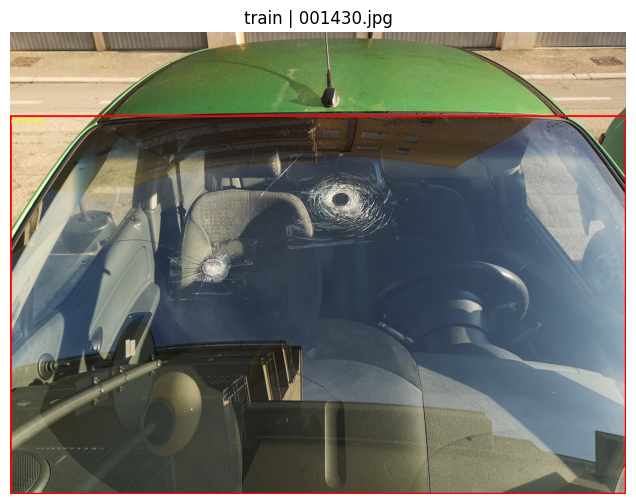

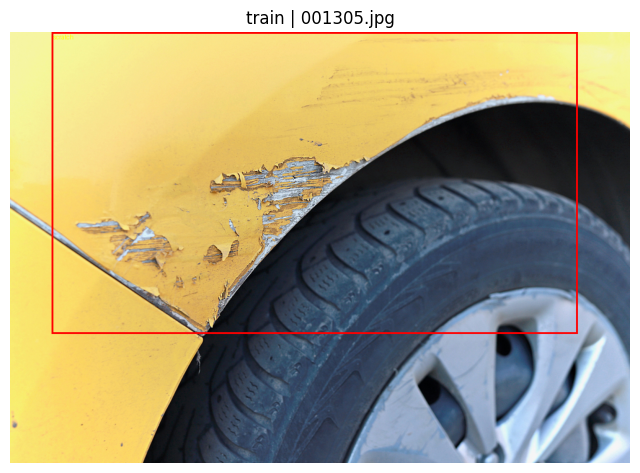

In [10]:
# Optional visualization QA: draw a few random boxes per split to confirm correctness.
def visualize_random(split, num_images=2, max_boxes=5):
    ann_path = OUTPUT_ROOT / split / "annotations" / "annotations.json"
    with open(ann_path, "r") as f:
        coco = json.load(f)

    anns_by_image = defaultdict(list)
    for ann in coco["annotations"]:
        anns_by_image[ann["image_id"]].append(ann)

    id_to_image = {img["id"]: img for img in coco["images"]}
    id_to_cat = {c["id"]: c["name"] for c in coco["categories"]}

    chosen = random.sample(list(id_to_image.keys()), k=min(num_images, len(id_to_image)))
    for img_id in chosen:
        img_info = id_to_image[img_id]
        img_path = OUTPUT_ROOT / split / "images" / img_info["file_name"]
        if not img_path.exists():
            print(f"Missing image for visualization: {img_path}")
            continue

        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        for ann in anns_by_image.get(img_id, [])[:max_boxes]:
            x, y, w, h = ann["bbox"]
            cat_name = id_to_cat.get(ann["category_id"], "?")
            draw.rectangle([x, y, x + w, y + h], outline="red", width=3)
            draw.text((x + 2, y + 2), cat_name, fill="yellow")

        plt.figure(figsize=(8, 6))
        plt.title(f"{split} | {img_info['file_name']}")
        plt.imshow(img)
        plt.axis("off")
        plt.show()

# Example (uncomment to run):
visualize_random("train", num_images=2)
